# Multiobjective control of cash management systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from gurobipy import *
from IPython.display import Image

## 1. Introduction

The cash management problem (CMP) aims to keep a balance between how much a company holds in cash and how much is allocated in short-term investments such as tresury bills or interest bearing accounts. The CMP is characterized by the particular form of the cash flow process and by a cost structure including holding and transaction costs. Holding costs are oportunity costs due to idle cash balances and transaction costs charge transfers between accounts.

## 2. Controlling cash within the (common) two-assets setting and the Miller-Orr model

The CMP has been usually approached as a control problem. The cash balance of any bank account needs to be monitored to keep the balance between two bounds, for instance, a low bound and a high bound. To this end, some control actions are taken to increase or decrease the balance according to some rules in order to minimize expected holding and transaction costs. The set of control actions deployed over a planning horizon, namely, the policy, is the solution to the CMP. 

Miller and Orr (1966) proposed a simple policy based on three bounds to control cash balances. This policy implies that when the upper bound $U$ is reached a withdrawal transfer is made to restore the balance to a target level $Z$. In the same way, when the cash balance reaches the lowe bound $L$, a positive transfer is made to restore the balance to $Z$. 

\begin{equation}
u_t=\left\{\begin{array}{lll}Z-b_{t}-f_t & \mbox{if} & b_{t} + f_t > U \\ 0 &\mbox{if} & L < b_{t} + f_t < U  \\Z-b_{t}-f_t & \mbox{if} & b_{t} + f_t < L \end{array}\right.
\end{equation}

This control action $u_t$ is made at the end of time step $t$ when the current state is $b_t$ is updated with cash flow $f_t$ and the state transition law is given by:

\begin{equation}
b_{t} = b_{t-1} + u_t + f_t
\end{equation}

where $f_{1,t}$ is assumed to be a Gaussian, uncorrelated and stationary cash flow process. Although Miller and Orr set the lower limit $L$ to zero, cash managers should set a lower limit above zero for precautionary motives. We can reasonably set a lower bound $L$ proportional to the standard deviation of the particular cash flow process under consideration. 


\begin{equation}
L = \xi \sigma
\end{equation}

whehre $\xi$ is a parameter reflecting the aversion to risk of cash managers. In the usual context of high penalty costs for negative cash balances, the higher the value of $\xi$ the more averse to risk they are. Typical values for $\xi$ are 2 or 3 resulting in either a probability of 0.95 or 0.99, respectively, of a negative cash balance from the lower bound $L$ for Gaussian cash flows. Later, we can set $Z$ and $U$ according to the formulas derived by Miller-Orr:

\begin{equation}
Z=L+\left(\frac{3\gamma_0\sigma^2}{4h}\right)^{1/3}
\end{equation}
and
\begin{equation}
U=3Z-2L.
\end{equation}

where $\gamma_0$ is the fixed transaction cost, $\sigma$ is the standard deviation of net cash flows and $h$ is the holding cost per money unit.

** Example 1.** Consider an uncorrelated normal cash flow process with zero mean and standard deviation 1 million euro. Assume also a holding cost per day of 0.02 % and a fixed transaction cost $\gamma_0$ of 50 € for both positive and negative transactions. By setting a risk parameter $\xi=2$ we can compute the bounds L, Z, and U that determines the Miller-Orr policy as follows:

In [2]:
sigma = 1e6
h = 0.0002
gamma0 = 50
xi = 2
L = xi * sigma
Z = L + ((3 * gamma0 * sigma ** 2)/(4 * h)) ** (0.333333)
U = 3 * Z - 2 * L
L,Z,U

(2000000.0, 2572349.5332918903, 3717048.599875671)

We are now in a position to simulate the behavior of this policy and estimate the expected cost of the Miller-Orr policy by means of the following class

In [3]:
class miller(object):
    
    def __init__(self, gzeropos, gzeroneg, h, p, L, Z, U):
        """Initializes model parameters"""
        self.gzeropos = gzeropos
        self.gzeroneg = gzeroneg
        self.h = h
        self.p = p
        self.U = U
        self.Z = Z
        self.L = L
        self.daily_cost = []
        self.cost_list =[]
        self.trans_list = []
        self.bal_list = []
        
    def transfer(self, cf, ob):
        """Determines transfer u from cash flow, opening balance (ob) and U, Z, L"""
        if ob + cf > self.U:
            u = self.Z - ob - cf
        elif ob + cf < self.L:
            u = self.Z - ob - cf
        else:
            u = 0
        return u
    
    def trans_cost(self, u):
        """Computes the cost of transfer u"""
        cost = 0
        if u < 0:
            cost = self.gzeroneg
        elif u > 0:
            cost = self.gzeropos
        return cost
    
    def holding_cost(self, final):
        """Computes the holding cost"""
        cost = 0
        if final >= 0:
            cost = self.h * final
        else: 
            cost = -self.p * final
        return cost
                
    def cost_calc(self, cf, ob):
        """Computes a vector of daily cost of cash flows and an opening balance"""
        inibal = ob
        bal = ob
        if len(self.daily_cost) > 0:
            del self.daily_cost[:]
        if len(self.trans_list) > 0:
            del self.trans_list[:]
        if len(self.bal_list) > 0:
            del self.bal_list[:]
        for element in cf:
            trans = self.transfer(element, inibal)
            self.trans_list.append(trans)
            bal = inibal + trans + element
            self.bal_list.append(bal)
            self.daily_cost.append(self.trans_cost(trans) + self.holding_cost(bal))
            inibal = bal
        return self.daily_cost
    
    def cost_calc_no_trans(self, cf ,ob):
        """Computes a vector of daily cost of cash flows and an opening balance"""
        inibal = ob
        bal = ob
        if len(self.daily_cost) > 0:
            del self.daily_cost[:]
        for element in cf:
            bal = inibal + element
            self.daily_cost.append(self.holding_cost(bal))
            inibal = bal
        return self.daily_cost

In [4]:
p = 0.3
T = 100
f = [sigma * np.random.randn() for i in range(T)]
m = miller(gamma0, gamma0, h, p, L, Z, U)
b0 = Z
cost_miller = np.round(np.mean(m.cost_calc(f, b0)), 2)
cost_trivial = np.round(np.mean(m.cost_calc_no_trans(f, b0)), 2)
print("Average cost Miller = ", cost_miller)
print("Average cost trivial = ", cost_trivial)

Average cost Miller =  571.72
Average cost trivial =  2260.24


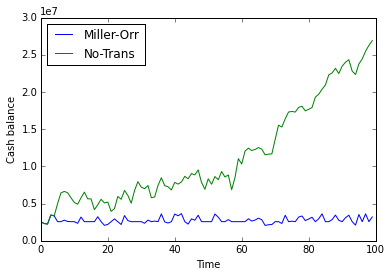

In [5]:
t = range(T)
plt.plot(t, m.bal_list, label = 'Miller-Orr')
trivial_bal = b0 + np.cumsum(f)
plt.plot(t, trivial_bal, label= 'No-Trans')
plt.xlabel('Time')
plt.ylabel('Cash balance')
plt.legend(loc='upper left')
plt.show()

**Figure 1.** Balance comparison between a Miller-Orr policy and a no-trans policy.

# 3. A control approach to the cash management problem

Consider a company with two bank accounts as depicted in the following figure. Account 1 receives payments from customers (inflows) and it is also used to send payments to suppliers (outflows). Both inflows and outflows are summarized through the net cash flow $f_{1,t}$.  Account 2 represents the amount of alternative investments available to be converted into cash through transaction $u_{1,t}$ when needed. In addition, idle cash balances from account 1 can be allocated in account 2 for a profit through transaction $u_{2,t}$.


Let $\boldsymbol{b}_t$ an $m \times 1$ vector describing the state of a cash management system at time t in terms of available cash balance and $\boldsymbol{u}_t$ a $n \times 1$ vector with control actions. The transition state equation is:

\begin{equation}
\boldsymbol{b}_{t} = A \cdot \boldsymbol{b}_{t-1} + B \cdot  \boldsymbol{u}_t + C \cdot  \boldsymbol{f}_{t}
\end{equation}

where $\boldsymbol{f}_{t}$ is a cash flow process of dimension $m \times 1$. By setting $A = 1$, $B = \left[ \begin{array}{rr} 1 & -1 \\  -1 & 1 \\ \end{array} \right]$, and $C = \left[ \begin{array}{rr} 1 & 0 \\  0 & 0 \\ \end{array} \right]$, we can represent the (common) two-assets setting shown in the figure.

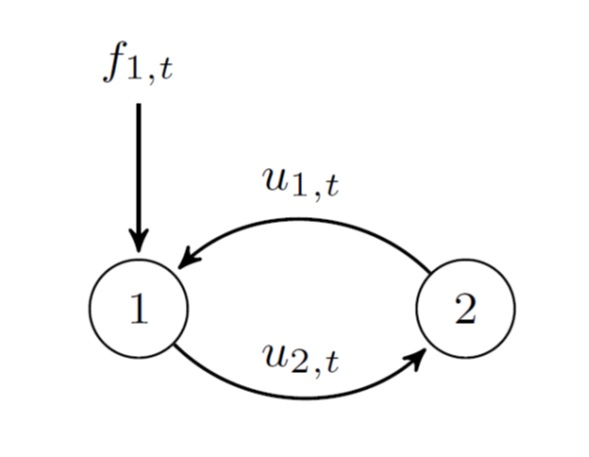

In [6]:
Image(filename="TwoAssets.jpg",embed=True,width=300,height=400)

**Figure 2.** The two-assets setting: circle 1 is a cash account and circle 2 is an investment account.

Then, the system behaviour is given by:

\begin{equation}
\left[ \begin{array}{r} b_{1,t} \\ b_{2,t} \\ \end{array} \right] = \left[ \begin{array}{r} b_{1,t-1} \\ b_{2,t-1} \\ \end{array} \right] + \left[ \begin{array}{rr} 1 & -1 \\  -1 & 1 \\ \end{array} \right] \left[ \begin{array}{r} u_{1,t} \\ u_{2,t} \\ \end{array} \right] + \left[ \begin{array}{rr} 1 & 0 \\  0 & 0 \\ \end{array} \right] \left[ \begin{array}{r} f_{1,t} \\ f_{2,t} \\ \end{array} \right]
\end{equation}

Next day balances are built by adding control actions and cash flow shocks according to $B$ and $C$:

\begin{equation}
b_{1,t}  = b_{1,t-1} + u_{1,t} - u_{2,t} +  f_{1,t} 
\end{equation}

\begin{equation}
b_{2,t}  = b_{2,t-1} - u_{1,t} + u_{2,t} 
\end{equation}

The objective of cash managers is to minimize holding and transaction costs:

\begin{equation}
y_t = \boldsymbol{h}' \cdot \boldsymbol{b}_t + \boldsymbol{\gamma}_1' \cdot  \boldsymbol{u}_t + \boldsymbol{\gamma}_0' \cdot \boldsymbol{z}_t
\end{equation}

where $\boldsymbol{h}$ is an $m \times 1$ vector with holding costs per money unit for each account, $\boldsymbol{\gamma}_1$ is and $n \times 1$ vector with variable transaction costs, and $\boldsymbol{\gamma}_0$ is and $n \times 1$ vector with fixed transaction costs. Since fixed transaction costs are only charged when a control action occurs, we need an auxiliary variable $z_t$ satisfying the following constraints (Bemporad and Morari, 1999):

\begin{equation}
k \cdot \boldsymbol{z}_t \leq \boldsymbol{u}_t \leq K \cdot \boldsymbol{z}_t
\end{equation}

where K (k) is a very large (small) number and:

\begin{equation}
z_{1,t} + z_{2,t} \leq 1
\end{equation}

to ensure that both transactions cannot occur at the same time. However, cash managers may be interested not only in the cost but also in the risk of alternative policies. In the usual context of much higher penalty costs for negative cash balances in comparison to holding costs for positive cash balances, minimum cash balances must be kept for precautionary purposes. Within an optimization framework, risk control can be achieved by setting a target cash balance as reference. Then, we transform the single objective problem into a multiobjective problem in which the goal is minimizing a weighted objective function as follows:

\begin{equation}
\operatorname{min} \sum_{t=1}^T  \left[ \frac{w_1}{C_{max}} \left( \boldsymbol{h}' \cdot \boldsymbol{b}_t + \boldsymbol{\gamma}_1' \cdot  \boldsymbol{u}_t + \boldsymbol{\gamma}_0' \cdot \boldsymbol{z}_t \right) + \frac{w_2}{R_{max}} \left( (\boldsymbol{b}_t - \boldsymbol{b}_{ref})' \cdot  Q \cdot (\boldsymbol{b}_t - \boldsymbol{b}_{ref})' \right) \right]
\end{equation}

where $\boldsymbol{b}_{ref}$ is a given balance reference, $w_1,w_2$ are weights reflecting risk preferences of cash managers subject to $w_1+w_2=1$, and $C_{max}$, $R_{max}$ are normalization factors to avoid meaningless comparison between cost and risk goals. These factors can also be viewed as budget constraints in terms of both cost and risk leading to an unfeasible policy when exceeded. Under this framework, risk control takes the form of minimizing squared deviations from a reference balance. Note also that $Q$ is used to select which accounts need to be controlled. For instance, if:

\begin{equation}
Q = \left[ \begin{array}{rr} 1 & 0 \\  0 & 1 \\ \end{array} \right]
\end{equation}

we are controlling balances for both account 1 and 2. However, if:

\begin{equation}
Q = \left[ \begin{array}{rr} 1 & 0 \\  0 & 0 \\ \end{array} \right]
\end{equation}

we are controlling only balances for account 1.

As a result, we are facing a multiobjective optimization problem in which cost and risk are desired goasl to minimize. This problem is econded as a Mixed Integer Quadratic Progam (MIQP) that can be solved using state-of-the-art mathematical programming solvers such as Gurobi. The following class **multibank** implements methods to solve this multiobjective cash management problem.


In [7]:
class multibank(object):
    
    def __init__(self, banks, trans, B, gzero, gone, h, bref, Q):
        """Defines the cash management system"""

        self.banks = list(banks)               # List of banks
        self.trans = list(trans)               # List of transactions
        self.B = np.array(B, dtype= int)       # Incidence matrix  
        self.gzero = gzero                     # Dict of fixed transaction cost
        self.gone = gone                       # Dict of variable transaction costs
        self.h = h                             # Dict of holding costs  
        self.bref = list(bref)                 # List of reference balances
        self.resx = []                         # Optimal policy
        self.resb = []                         # Optimal balance
        self.Q = np.array(Q, dtype=int)        # i-th elem of diagonal set to 1 if account i is referenced  
        

        # Checks types of input data
        if type(self.gzero) != dict:
            self.gzero = dict([(i,0) for i in self.trans])
            self.B = np.zeros((len(self.trans), len(self.banks)))
            print("Fixed costs must be a dictionary")
        if type(self.gone) != dict:
            self.gone = dict([(i,0) for i in self.trans])
            self.B = np.zeros((len(self.trans), len(self.banks)))
            print("Variable costs must be a dictionary")
        if type(self.h) != dict:
            self.h = dict([(i,0) for i in self.banks])
            self.B = np.zeros((len(self.trans), len(self.banks)))
            print("Holding costs must be a dictionary")
        
        # Checks dimension agreement 
        if self.B.shape != (len(self.trans), len(self.banks)):
            self.B = np.zeros((len(self.trans), len(self.banks)))
            print("Incidence matrix dimensions do not agree with banks or transactions")
        if len(self.bref) != len(self.banks):
            self.bref = []
            print("Reference balances must agree with banks")
        if len(self.gzero) != len(self.gone):
            self.gzero = []
            self.gone = []
            print("Fixed and variable transaction costs must agree")
        if len(self.gzero) != len(self.trans):
            self.trans = []
            print("Transaction costs must agree with transactions")
        if len(self.h) != len(self.banks):
            self.banks = []
            print("Holding costs must agree with banks")
        if len(self.banks) <= 1:
            self.banks = []
            print("A system must have at least two banks")

    def describe(self):
        """Describe the main characteristics of the system"""

        print('Banks =', self.banks)
        print('Trans =', self.trans)
        print('Incidence matrix B =', self.B.tolist())
        print('Fixed costs =', self.gzero)
        print('Variable costs =', self.gone)
        print('Holding costs =', self.h)
        print('Reference balances =', self.bref)
        print('Balance control matrix Q =', self.Q.tolist())
        
    
    def solveref(self, b0, fcast, Cmax, Rmax, w1, w2):
        """Solve mba problem from initial balance b0 and forecast fcast
        fcast: an h x m matrix with h forecasts for m accounts
        b0: list with initial balances for each account
        """
        
        # Reset solution values 
        self.resx = []                         # Optimal policy
        self.resb = []                         # Optimal cash balance
        self.objval = 0                        # Objective value
     
        
        # Checks dimensions
        fcast = np.array(fcast)
        if len(fcast) <= len(self.banks): 
            fcast = fcast.reshape((1,len(self.banks)))              
        self.T = fcast.shape[0]
        
        if len(b0) != len(self.banks):
            return (print("Dimension for minimum balances must agree with banks"))
        
        if fcast.shape != (self.T, len(self.banks)):
            return (print("Dimensions for forecasts must agree with horizon and banks"))
                    
        # Init model
        m = Model("example")

        #Ranges
        tr_range = range(len(self.trans))
        bk_range = range(len(self.banks))
        time_range = range(self.T)

        # Fixed costs: z = 1 if trans occurs at time tau
        fixed = []
        for tau in time_range:
            fixed.append([])
            for t in self.trans:
                fixed[tau].append(m.addVar(vtype = GRB.BINARY, name = "z%d,%d" %(tau, t)))
        m.update()

        # Variable costs are proportional to transaction decision variables
        var = []
        for tau in time_range:
            var.append([])
            for t in self.trans:
                var[tau].append(m.addVar(vtype = GRB.CONTINUOUS, name = "u%d,%d" %(tau, t)))
        m.update()

        # Holding costs are proportional to balance auxiliary decision variables
        bal = []
        for tau in time_range:
            bal.append([])
            for j in self.banks:
                bal[tau].append(m.addVar(vtype = GRB.CONTINUOUS, name="b%d,%d" %(tau, j)))
        m.update()
        

        # Intitial transition constraints and minimum balance constraints
        for j in bk_range:
            m.addConstr(b0[j] + fcast[0][j] + LinExpr(self.B[j], var[0][:]) == bal[0][j], 'IniBal%d'% j)
        m.update()

        # Rest of transition constraints
        for tau in range(1, self.T):
            for j in bk_range:
                m.addConstr(bal[tau-1][j] + fcast[tau][j] + LinExpr(self.B[j],var[tau][:]) == bal[tau][j], 'Bal%d,%d'%(tau, j))
        m.update()

        # Bounds and binary variables constraints
        K = 9999                                 # K is a very large number with respect to control actions u_t
        k = 0.0001                               # k is a very small number with respect to control actions u_t
        for tau in time_range:
            for i in tr_range:
                m.addConstr(var[tau][i] <= K * fixed[tau][i], name = "c%d%d" %(tau, i))  
                m.addConstr(var[tau][i] >= k * fixed[tau][i], name="c2%d%d" %(tau, i))  
        m.update() 

        # Setting the objectives
        transcost = sum([self.gzero[t] * fixed[tau][t-1] + self.gone[t] * var[tau][t-1] 
                         for tau in time_range for t in self.trans])
        holdcost = sum([self.h[j] * bal[tau][j-1] for tau in time_range for j in self.banks])
        q = np.diag(self.Q)
        devcost = sum([q[j] * (self.bref[j] - bal[tau][j]) * (self.bref[j] - bal[tau][j]) 
                       for tau in time_range for j in bk_range])
        m.setObjective((w1 / Cmax) * (transcost + holdcost) + (w2 / Rmax) * devcost, GRB.MINIMIZE)
        m.update()

        # Budget constraints
        m.addConstr(transcost + holdcost <= Cmax, name = "CostBudget")
        m.addConstr(devcost <= Rmax, name = "RiskBudget")
        m.update()

        # Optimization
        m.setParam('OutputFlag', 0) 
        m.optimize()

        # Checks if model is optimal and present results        
        if m.status == 2: 
            self.objval = m.ObjVal
            for dv in m.getVars():
                if 'u' in dv.varName:
                    self.resx.append([dv.varName, dv.x])
                if 'b' in dv.varName:
                    self.resb.append([dv.varName, dv.x])
            return(print("Program successfully solved"))
        else:
            return(print("I was unable to find a solution"))

    def policy(self): 
        """Returns a matrix with policy for each transaction"""
        if len(self.resx) > 0:
            plan = np.array(self.resx)
            planmat = np.array([float(i) for i in plan[:,1]]).reshape((self.T,len(self.trans)))
            return(planmat)
        else:
            return(print("Nothing to show"))
    
    def balance(self):
        """Returns a matrix with balances for each bank account"""
        if len(self.resb) > 0:
            bals = np.array(self.resb)
            balsmat = np.array([float(i) for i in bals[:,1]]).reshape((self.T,len(self.banks)))
            return(balsmat)
        else:
            return(print("Nothing to show"))

**Example 2.**  As an illustrative example, consider a cash management system like the one depicted in Figure 2. Let us consider the following input data including transaction and holding costs. Assume Gaussian cash flows for account 1 distributed according to $\mathcal{N}(0,1)$. Thus, we can reasonably set a cash balance reference equal to three times the volatility introduced by cash flow random shocks. Then, on average, only one out of one hundred times will drop from the reference to a negative cash balance.

In [8]:
# Input data for the Example 2. Balance figures in millions.

# Bank accounts
banks = [1,2]
m = len(banks)

# Transactions
trans = np.array([1,2])
n = len(trans)

# Allowed transactions between accounts
B = np.array([[1, -1],[-1, 1]])

# Transaction fixed costs
g0 = {1:50, 2:50}                      # Dictionary indexes must match the list of transactions

# Transaction variable costs
g1 = {1:10, 2:50}                      # Dictionary indexes must match the list of transactions

# Holding costs per bank account
h = {1:200, 2:0}                       # Dictionary indexes must match the list of banks

# Minimum balances
bref = [3, 0]

# Referenced accounts
Q = np.array([[1, 0],[0,0]])

Then, we can create an instance of the class multibank as follows:

In [9]:
prb = multibank(banks, trans, B, g0, g1, h, bref, Q)
prb.describe()

Banks = [1, 2]
Trans = [1, 2]
Incidence matrix B = [[1, -1], [-1, 1]]
Fixed costs = {1: 50, 2: 50}
Variable costs = {1: 10, 2: 50}
Holding costs = {1: 200, 2: 0}
Reference balances = [3, 0]
Balance control matrix Q = [[1, 0], [0, 0]]


Assume first a neutral cash manager, i.e., without preference for cost and risk. This assumption implies $w_1=w_2=0.5$. Furthermore, we impose both a total cost and a total risk budget constraints. For instance, two times the total holding cost for  the reference balance for the cost budget. And a maximum deviation of half the reference balance for the risk budget.

In [10]:
# Set preferences for goals and 
w1 = 0.5
w2 = 1 - w1

# Planning horizon
T = 20

# Two arbitrary parameters
p1 = 1.5    # Parameter to set Cmax (number of times of holding cost of bref as max daily cost)
p2 = 1      # Paraemter to set Rmax (percentage of bref as max daily deviation)

# Cost/risk budget constraints
Cmax = p1 * bref[0] * h[1] * T
Rmax = (p2 * bref[0]) ** 2 * T 
Cmax, Rmax

(18000.0, 180)

We set an initial cash balance and generate a random cash flow for account 1 according to Figure 2 to solve the problem.

In [11]:
# Initial balance and random cash flow for a planning horizon T
b0 = [3, 3]
f = np.hstack((np.random.randn(T, 1),np.zeros((T,m-1))))

# Solve the problem for this cash flow
sol = prb.solveref(b0, f, Cmax, Rmax, w1, w2)
sol
print("Objective value = ", round(prb.objval,2))

Program successfully solved
Objective value =  0.31


It is also interesting to retrieve both the policy and the resulting balance to verify that the actual cost/risk of deploying the policy is the previous objective value.

In [12]:
# Retrieving the policy and the resulting balance
X = prb.policy()
Bal = prb.balance()

#Some useful vectors to compute cost and risk
vh = np.array(list(h.values())).reshape((m,1))
vg0 = np.array(list(g0.values())).reshape((n,1))
vg1 = np.array(list(g1.values())).reshape((n,1))
cost = np.sum(np.dot(vh.T,Bal.T)) + np.sum(np.dot(vg0.T,np.sign(X.T))) + np.sum(np.dot(vg1.T,X.T))
Bref = np.array(bref).reshape((1,m))
D = Bref - Bal
Qv = np.diag(Q).reshape((m,1))
risk = np.sum(np.dot(D,Qv)**2)

print("Total cost = ", round(cost,2))
print("Total risk = ", round(risk,2))
print("Objective value = ", round(w1/Cmax * cost + w2/Rmax * risk,2))

Total cost =  8613.34
Total risk =  25.08
Objective value =  0.31


Finally, we can plot the resulting cash balance and make some interesting computations

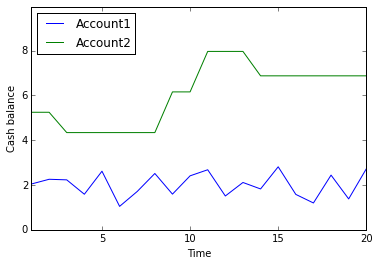

In [13]:
time = range(1,T+1)
for i in range(m):
    plt.plot(time, Bal[:,i],label='Account'+ str(i+1))
plt.legend(loc='upper left')
plt.ylim([0,max(Bal.flatten())+2])
plt.xlim([1,T])
plt.xlabel('Time')
plt.ylabel('Cash balance')
plt.show()

In [14]:
print("Average balance for account 1 =", round(np.mean(Bal[:,0]),2))
print("Standard deviation for account 1 =", round(np.std(Bal[:,0]),2))
print("Average balance for account 2 =", round(np.mean(Bal[:,1]),2))
print("Standard deviation for account 2 =", round(np.std(Bal[:,1]),2))

Average balance for account 1 = 2.01
Standard deviation for account 1 = 0.53
Average balance for account 2 = 6.04
Standard deviation for account 2 = 1.31


Within this framework, let us change the risk preferences to consider a much more conservative cash manager.

In [15]:
# Changing risk preferences
w1 = 0.2
w2 = 1 - w1

sol = prb.solveref(b0, f, Cmax, Rmax, w1, w2)

# Retrieving the policy and the resulting balance
X = prb.policy()
Bal = prb.balance()

#Some useful vectors to compute cost and risk
vh = np.array(list(h.values())).reshape((m,1))
vg0 = np.array(list(g0.values())).reshape((n,1))
vg1 = np.array(list(g1.values())).reshape((n,1))
cost = np.sum(np.dot(vh.T,Bal.T)) + np.sum(np.dot(vg0.T,np.sign(X.T))) + np.sum(np.dot(vg1.T,X.T))
Bref = np.array(bref).reshape((1,m))
D = Bref - Bal
Qv = np.diag(Q).reshape((m,1))
risk = np.sum(np.dot(D,Qv)**2)

print("Total cost = ", round(cost,2))
print("Total risk = ", round(risk,2))
print("Objective value = ", round(w1/Cmax * cost + w2/Rmax * risk,2))

Program successfully solved
Total cost =  12459.14
Total risk =  1.55
Objective value =  0.15


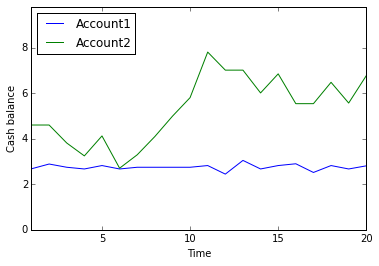

In [16]:
time = range(1,T+1)
for i in range(m):
    plt.plot(time, Bal[:,i],label='Account'+ str(i+1))
plt.legend(loc='upper left')
plt.ylim([0,max(Bal.flatten())+2])
plt.xlim([1,T])
plt.xlabel('Time')
plt.ylabel('Cash balance')
plt.show()

In [17]:
print("Average balance for account 1 =", round(np.mean(Bal[:,0]),2))
print("Standard deviation for account 1 =", round(np.std(Bal[:,0]),2))
print("Average balance for account 2 =", round(np.mean(Bal[:,1]),2))
print("Standard deviation for account 2 =", round(np.std(Bal[:,1]),2))

Average balance for account 1 = 2.75
Standard deviation for account 1 = 0.13
Average balance for account 2 = 5.3
Standard deviation for account 2 = 1.42


** References **

Miller, Merton H., and Daniel Orr. "A Model of the Demand for Money by Firms." The Quarterly journal of economics 80.3 (1966): 413-435.

Bemporad, Alberto, and Manfred Morari. "Control of systems integrating logic, dynamics, and constraints." Automatica 35.3 (1999): 407-427.